In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
a = pd.read_csv('data/babynames/yob1880.txt', names=['name', 'sex', 'births'])
a.head(5)

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746


In [3]:
columns = ['name', 'sex', 'births']
names = pd.DataFrame(columns=['name', 'sex', 'births','year'])
for i in range(1880, 2011) :

    tmp = pd.read_csv('babynames/yob%s.txt' % i, names=columns)
    tmp['year'] = i
    names = pd.concat([names, tmp], axis=0, ignore_index=True)
    

In [4]:
names.head(5)

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


##### index是x轴,最后求出来的结果是y轴,columns是你需要的分组

In [5]:
total_births = names.pivot_table('births', index=['year'], columns=['sex'], aggfunc=sum)
total_births = pd.DataFrame(total_births)
total_births.head(5)

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445


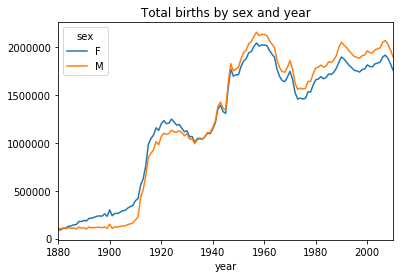

In [6]:
total_births.plot(title='Total births by sex and year')

In [18]:
def add_prop(group):
    group['prob'] = group.births / group.births.sum()
#     group['prob'] = group.births / group.groupby(['year']).agg({"births":sum})
    return group

In [21]:
names = names.groupby(['year','sex']).apply(add_prop)

In [41]:
names.head(5)

,name,sex,births,year,prob
0,Mary,F,7065,1880,0.0776433
1,Anna,F,2604,1880,0.0286176
2,Emma,F,2003,1880,0.0220127
3,Elizabeth,F,1939,1880,0.0213093
4,Minnie,F,1746,1880,0.0191883


In [25]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]

In [51]:
top1000 = names.groupby(['year','sex']).apply(get_top1000)['name'].reset_index()

In [52]:
top1000.head(1)

,year,sex,level_2,name
0,1880,F,0,Mary


In [55]:
top1000 = pd.merge(names, top1000)[['name', 'sex', 'births', 'year', 'prob']]

In [59]:
top1000.head(1)

,name,sex,births,year,prob
0,Mary,F,7065,1880,0.0776433


#### 分析命名趋势

In [62]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

In [71]:
total_births = top1000.pivot_table('births', index=['year'], columns=['name'], aggfunc=sum)

In [73]:
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000016ED31390>,
      dtype=object)

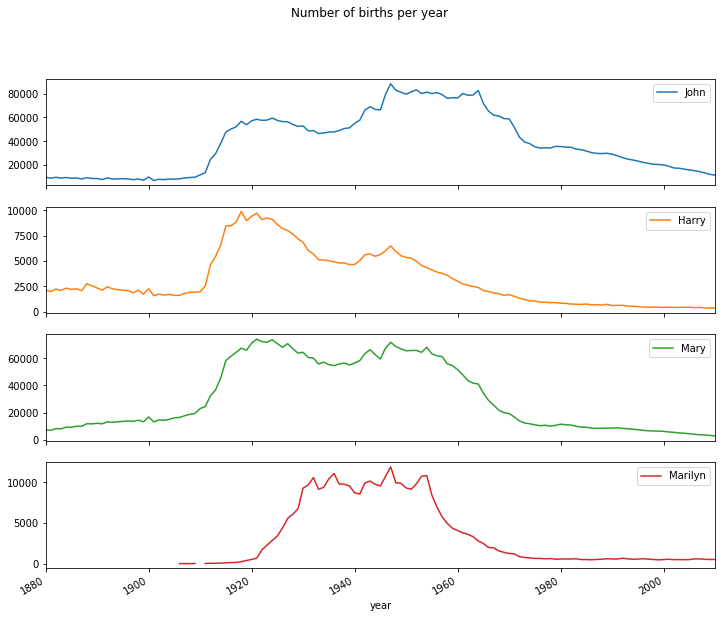

In [78]:
subset.plot(subplots=True, figsize=(12, 10), grid=False,title="Number of births per year")

#### 评估命名多样性的增长

In [85]:
table = top1000.pivot_table('prob', index='year', columns='sex', aggfunc=sum)

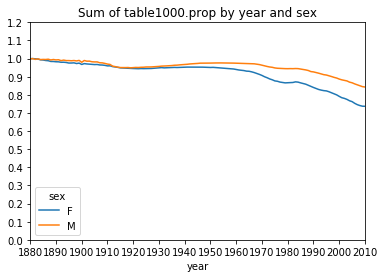

In [95]:
table.plot(title='Sum of table1000.prop by year and sex' ,yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

#### 计算占总出生人数前50%的不同名字的数量

In [118]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prob', ascending=False).prob.cumsum()
    return np.searchsorted(group, q)[0] + 1

In [126]:
diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

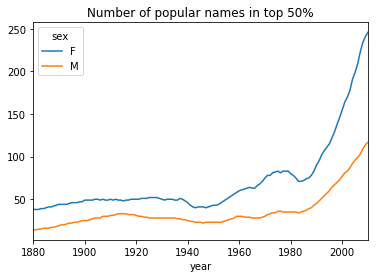

In [127]:
diversity.plot(title="Number of popular names in top 50%")

#### “最后一个字母”的变革

In [133]:
get_last_letter = lambda x :x[-1]
last_letters = names.name.apply(get_last_letter)

In [136]:
names['last_letter'] = last_letters
names.head(5)

,name,sex,births,year,prob,last_letter
0,Mary,F,7065,1880,0.0776433,y
1,Anna,F,2604,1880,0.0286176,a
2,Emma,F,2003,1880,0.0220127,a
3,Elizabeth,F,1939,1880,0.0213093,h
4,Minnie,F,1746,1880,0.0191883,e


In [210]:
# table = names.pivot_table('births', index='last_letter',columns=['year','sex'], aggfunc=sum)
table = names.pivot_table('births', index=last_letters, columns=['sex', 'year'], aggfunc=sum)

In [211]:
subtable = table.reindex(columns=[1910,1960,2010],level='year')
subtable.head(5)

sex          F                            M                    
year      1910      1960      2010     1910      1960      2010
name                                                           
a     108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b          NaN     694.0     450.0    411.0    3912.0   38859.0
c          5.0      49.0     946.0    482.0   15476.0   23125.0
d       6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e     133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

In [212]:
letter_prop = subtable / subtable.sum()
letter_prop.head(5)

sex          F                             M                    
year      1910      1960      2010      1910      1960      2010
name                                                            
a     0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b          NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c     0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d     0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e     0.336941  0.215133  0.178415  0.147556  0.083853  0.067959

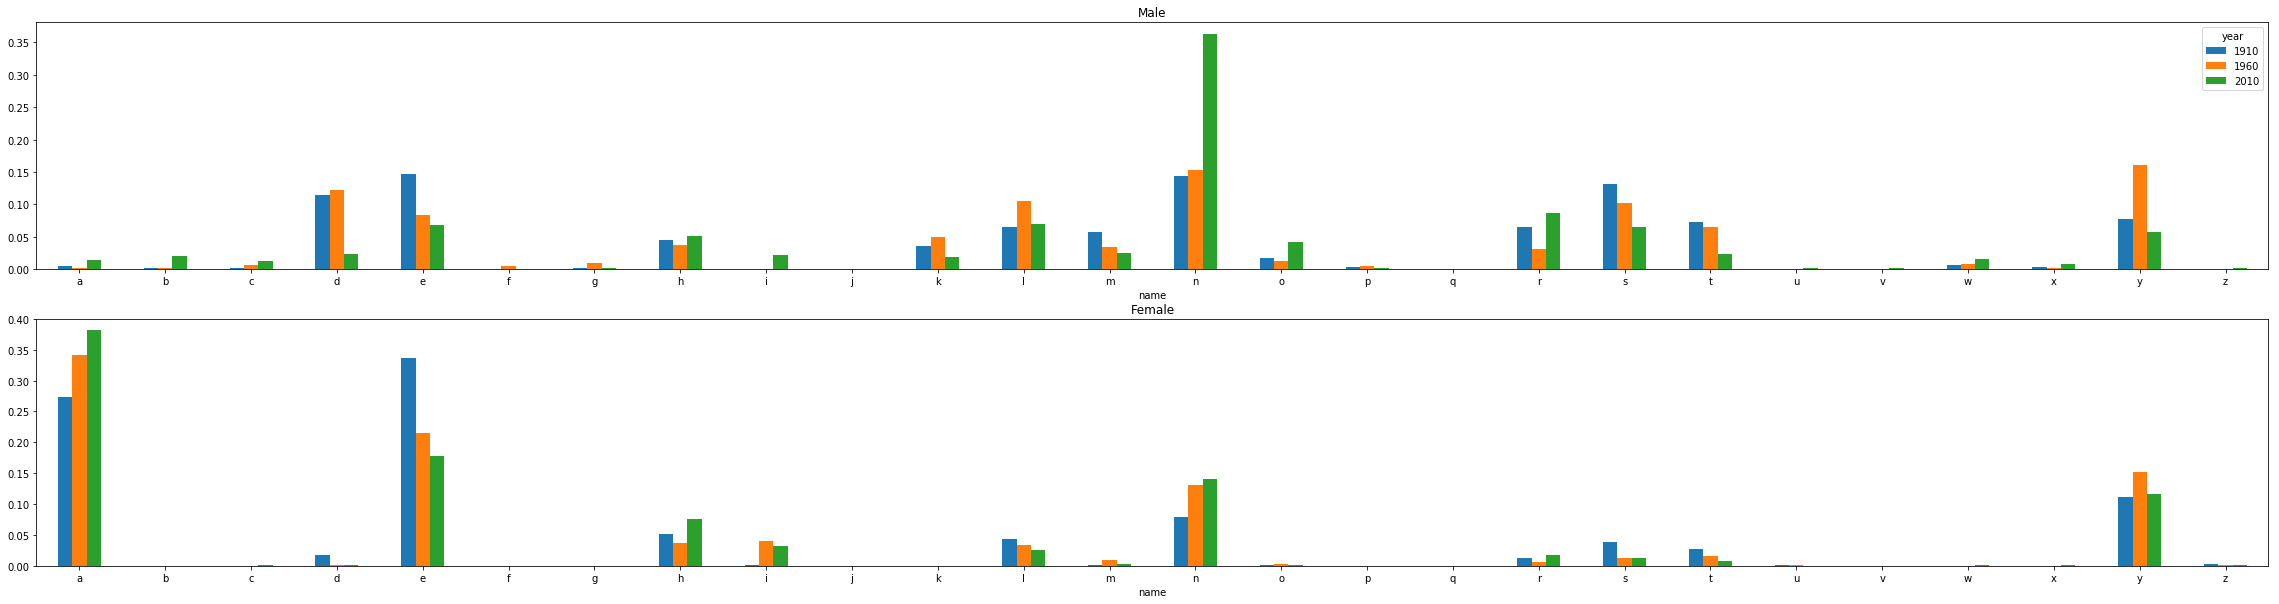

In [218]:
fig, axes = plt.subplots(2, 1, figsize=(40, 10))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female', legend=False)

In [227]:
letter_prop = table / table.sum()
dny_ts = letter_prop.loc[['d', 'n', 'y']].M.T

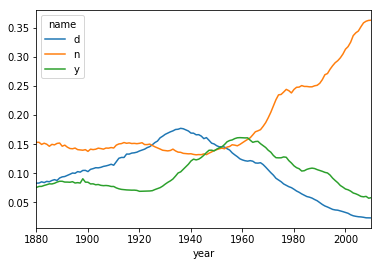

In [228]:
dny_ts.plot()

#### 变成女孩名字的男孩名字

In [252]:
all_names = top1000.name.unique()

lesley_like = []
for name in all_names:
    if name.lower().find("lesl") == 0:
        lesley_like.append(name)

In [250]:
filtered = top1000

In [266]:
filtered = top1000[top1000.name.isin(lesley_like)]
filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

>pivot_table中x轴是index,aggfunc作用在第一个参数上行程y轴，columns用来分组，表示对比项，即是透视表的筛选条件

In [270]:
table = filtered.pivot_table('births', columns='sex', index='year', aggfunc='sum')

In [286]:
table = table.div(table.sum(1), axis=0)

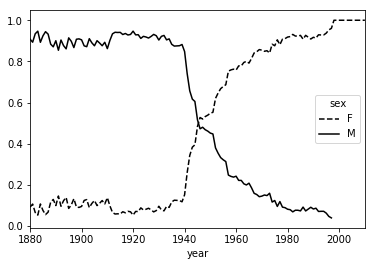

In [290]:
table.plot(style={'M': 'k-', 'F': 'k--'})